# Calculate daily modulation of signal strength

Finding: $\boldsymbol{n} \cdot \boldsymbol{n}_{\odot} = \cos{\gamma(t)}$ where $\boldsymbol{n}$ is the unit vector pointing between cavities at NPL and PTB and $\boldsymbol{n}_{\odot}$ is the unit vector pointing to Cygnus (direction of Earth's motion w.r.t. DM halo)

Notebook calculates the above over a 2 day period starting 15th July 2019 00:00 UTC in the follow steps:

* Convert the lat. long. el. of the cavities (at NPL and PTB) to Earth-Centered Earth-Fixed (ECEF) frame
* Convert the ECEF coords of cavities to Earth-Centered Intertial (ECI) frame for a list of dates that covers a 48 hour period after 2019-07-15 00:00 UTC
* Subtract cavity coordinates from eachother and normalise to get the NPL-PTB unit vector
* Calculate scalar product of the unit vector pointing to Cygnus and NPL-PTB unit vector through time
* Find portion that corresponds to the times that data was taken (2019-07-15 15:23 UTC to 2019-07-16 02:47 UTC)
* Calculate average -> this gives the fraction that the signal strength needs to be multiplied

In [1]:
import pymap3d as pm
import datetime as dt
import matplotlib.pyplot as plt
import numpy as np

# import matplotlib.font_manager as fm
# making font look nice for later plot
# fm.rcParams['font.family'] = ['serif']
# fm.rcParams['mathtext.fontset'] = 'cm'

In [2]:
# unit vector in direction of Cygnus
eciCyg = 0.46, -0.49, 0.74
# geodetic coordinates of NPL (Teddington) and PTB (Braunschweig)
geoNPL = 51.4268, 0.3442, 24
geoPTB = 52.2950, 10.4578, 75

# converting NPL & PTB coords to ECEF (Earth-Centered Earth-Fixed)
ecefNPL = pm.geodetic2ecef(*geoNPL)
ecefPTB = pm.geodetic2ecef(*geoPTB)

The data used was sourced from: https://doi.org/10.5281/zenodo.5717954 [Schioppo et al., Nat. Commun. 13 212 (2022)]

Using file titled: "833000_s_874000_s_data_for_fig_2.txt",
where the numbers indicate the number of seconds after 6th July 2019 00:00 UTC (first number gives start time, seconds gives end time)
* 833000 seconds after 2019-07-06 00:00 = 2019-07-15 15:23:20 UTC
* 874000 seconds after 2019-07-06 00:00 = 2019-07-16 02:46:40 UTC

To get a broader view, $k \cdot \Delta x$ is calculated for a 48 hour period starting on 15th July 2019 00:00 UTC 

In [3]:
# 6th July 2019 00:00 UTC
reftime = dt.datetime(2019, 7, 6, 0, 0, 0)
# 15th July 2019 00:00 UTC
daystart = dt.datetime(2019, 7, 15, 0, 0, 0)
# 15th July 2019 15:23 UTC
runstart = dt.datetime(2019, 7, 15, 15, 23, 0)
# 16th July 2019 02:46 UTC
runend = dt.datetime(2019, 7, 16, 2, 47)

# setting up list containing all dates and times over 48 hours
days_m = 2 * (24 * 60)
minlist = range(days_m + 1)
dtlist = [daystart + dt.timedelta(minutes=x) for x in minlist]

# finding sublist that covers the times of the existing data
start_index = [i for i, x in enumerate(dtlist) if x == runstart][0]
end_index = [i for i, x in enumerate(dtlist) if x == runend][0]

In [4]:
# set up arrays for ECI coords
eciNPL = []
eciPTB = []
for i in minlist:
    # ecef to eci requires time
    tmpNPL = pm.ecef2eci(*ecefNPL, time=dtlist[i])
    eciNPL.append(tmpNPL)
    tmpPTB = pm.ecef2eci(*ecefPTB, time=dtlist[i])
    eciPTB.append(tmpPTB)

normdiff = []
for i in minlist:
    # finding vector pointing from one cavity to the other and normalising
    xdiff = eciNPL[i][0] - eciPTB[i][0]
    ydiff = eciNPL[i][1] - eciPTB[i][1]
    zdiff = eciNPL[i][2] - eciPTB[i][2]
    diff = xdiff, ydiff, zdiff
    norm = np.sqrt(xdiff * xdiff + ydiff * ydiff + zdiff * zdiff)
    normdiff.append(diff / norm)

cygdotdiff_kdx = []
for i in minlist:
    # (separation unit vector) dot (Cygnus unit vector)
    dotprod = (
        normdiff[i][0] * eciCyg[0]
        + normdiff[i][1] * eciCyg[1]
        + normdiff[i][2] * eciCyg[2]
    )
    cygdotdiff_kdx.append(dotprod)

# averaging over the data time
print(np.mean(cygdotdiff_kdx[start_index:end_index]))

-0.41509007919670454


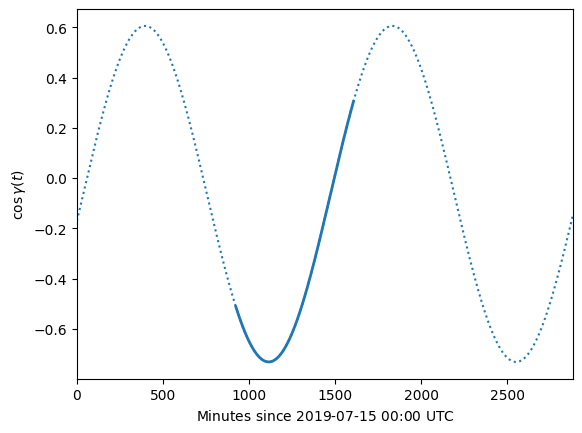

In [5]:
plt.plot(
    minlist,
    cygdotdiff_kdx,
    ls=":",
)
plt.plot(
    minlist[start_index:end_index],
    cygdotdiff_kdx[start_index:end_index],
    color="C0",
    ls="-",
    lw=2,
)
plt.xlim(0, minlist[-1])
plt.xlabel(r"$\mathrm{Minutes \ since \ 2019}$-$07$-$15 \ 00$:$00 \ \mathrm{UTC}$")
plt.ylabel(r"$\cos{\gamma{(t)}}$")
plt.show()